# 100 Pytorch Object Detection Exercises

The goal of this collection is to offer a quick reference for both old and new users who are designing and prototyping object detection algorithms with pytorch. 

In [1]:
import torch
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

def show_boxes(lims=(0,6), **boxes):
    """ Helper function to plot gt and anchors. 
    """
    gt_boxes = boxes['gt'] if 'gt' in boxes else []
    anchor_boxes = boxes['anchor'] if 'anchor' in boxes else []
    
    plt.figure()
    currentAxis = plt.gca()
    for box in gt_boxes:
        currentAxis.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=None, alpha=1, color='g'))

    for anchor in anchor_boxes:
        currentAxis.add_patch(Rectangle((anchor[0], anchor[1]), anchor[2]-anchor[0], anchor[3]-anchor[1], fill=None, alpha=1, color='r'))

    plt.ylim(lims)
    plt.xlim(lims)
    plt.show()

#### 1. Generate coordinates of anchor boxes
```python
base_size = 16 # pixel size in original image, also named stride or downsampling factor. 
scale_ls = [8, 16, 32] # under the same aspect ratio, scale = w_a/w_b or h_a/h_b
ratio_ls = [0.5, 1, 2] # under the same scale, ratio = height/width
```

In [33]:
# code reference: https://github.com/NVIDIA/retinanet-examples/blob/c1ba8e7a9ffa036a387387426682e1a7b58ec707/retinanet/box.py#L5
scale_ls = [8,16,32]
ratio_ls = [0.5,1,2] 
base_size = 16
def get_base_anchors(scale_ls, ratio_ls, base_size):
    """ Get the base anchors over one cell.
    """
    scales = torch.FloatTensor(scale_ls).repeat(len(ratio_ls), 1) # shape: (len(ratio_ls), len(scale_ls)), (3,3)
    scales = scales.transpose(0, 1).contiguous().view(-1, 1) # shape: (len(ratio_ls)*len(scale_ls), 1), (9,1)
    ratios = torch.FloatTensor(ratio_ls).repeat(len(scale_ls)) # shape: (len(ratio_ls)*len(scale_ls),), (9,)
    
    base_wh = torch.FloatTensor([base_size]).repeat(len(ratios), 2) # base width and height, shape: (9,2)
    anchor_w = torch.round(torch.sqrt(base_wh[:, 0] * base_wh[:, 1] / ratios)) # anchor width, shape: (9,)
    anchor_h = torch.round(anchor_w * ratios) # anchor height, shape: (9,)
    anchor_wh = torch.stack((anchor_w, torch.round(anchor_w * ratios)), dim=1) # anchor width and height, shape: (9,2)
    
    # calculate the relative center coordinates, then the diff is the xmin,ymin and xmax,ymax
    xy_min = 0.5*(base_wh-1) - 0.5*(anchor_wh* scales-1)
    xy_max = 0.5*(base_wh-1) + 0.5*(anchor_wh* scales-1)
    anchor_coord = torch.cat([xy_min, xy_max], dim=1)
    
    return anchor_coord

get_base_anchors(scale_ls, ratio_ls, base_size)

tensor([[ -84.,  -40.,   99.,   55.],
        [ -56.,  -56.,   71.,   71.],
        [ -36.,  -80.,   51.,   95.],
        [-176.,  -88.,  191.,  103.],
        [-120., -120.,  135.,  135.],
        [ -80., -168.,   95.,  183.],
        [-360., -184.,  375.,  199.],
        [-248., -248.,  263.,  263.],
        [-168., -344.,  183.,  359.]])

#### 2. Generate all anchors over the feature map

```python
feat_size = 28 # image size = feat_size * stride
stride = 16
scale_ls = [8,16,32]
ratio_ls = [0.5,1,2]
```

In [34]:
scale_ls = [8,16,32]
ratio_ls = [0.5,1,2] 
stride = 16
feat_size = 28

base_anchors = get_base_anchors(scale_ls, ratio_ls, stride)

def get_all_anchors(base_anchors, feat_size, stride):
    """ Get all anchors over the entire feature map. 
    
    Anchor coordinates could be outside the image.
    """
    shift_x, shift_y = torch.meshgrid(torch.arange(0, feat_size*stride, stride), torch.arange(0, feat_size*stride, stride))
    shift_xyxy = torch.stack((shift_x,shift_y,shift_x,shift_y),dim=2).to(dtype=torch.float32) # shape: (feat_size,feat_size,4)
    base_anchors = base_anchors.view(-1,1,1,4)
    all_anchors = (shift_xyxy+base_anchors).contiguous().view(-1,4)
    
    return all_anchors

get_all_anchors(base_anchors, feat_size, stride)

tensor([[-84., -40.,  99.,  55.],
        [-84., -24.,  99.,  71.],
        [-84.,  -8.,  99.,  87.],
        ...,
        [264.,  56., 615., 759.],
        [264.,  72., 615., 775.],
        [264.,  88., 615., 791.]])

#### 3. Sort the anchors based on the IoU with groud truth boxes
```python
boxes = [[0.5,0.5,1.5,1.5],[2.5,2.5,5.,5.]]
anchors = [[0.2,1.,2.,2.],[1.2,1.7,3.,3.6],[2.2,1.8,4.5,4.3]]
```

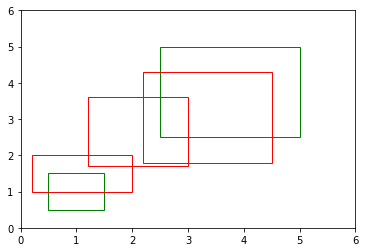

(tensor([0.2174, 0.0733, 0.4286]), tensor([0, 1, 1]))

In [36]:
boxes = [[0.5,0.5,1.5,1.5],[2.5,2.5,5.,5.]]
anchors = [[0.2,1.,2.,2.],[1.2,1.7,3.,3.6],[2.2,1.8,4.5,4.3]]

show_boxes(gt=boxes, anchor=anchors)

def sort_anchor_with_iou(boxes, anchors):
    """ Sort anchors based on iou with gt boxes.
    """
    boxes = torch.Tensor(boxes)
    anchors = torch.Tensor(anchors)
    xy1 = torch.max(anchors[:, None, :2], boxes[:, :2]) # broadcasting
    xy2 = torch.min(anchors[:, None, 2:], boxes[:, 2:])
    inter = torch.prod((xy2-xy1).clamp(0), dim=-1)
    boxes_area = torch.prod(boxes[:, 2:] - boxes[:, :2], dim=-1)
    anchors_area = torch.prod(anchors[:, 2:] - anchors[:, :2], dim=-1)
    iou = inter / ((boxes_area[:, None]+anchors_area).view(inter.size()) - inter)
    iou, indices = iou.max(-1) # iou shape: (num_anchors,), the elements in indices are index of gt box.
    return iou, indices

sort_anchor_with_iou(boxes, anchors) # [0.2174, 0.0733, 0.4286], [0, 1, 1], it means that the first anchor has the max iou 0.2174 with 0-th gt box.

#### 4. Convert class label to one hot
```python
cls_num = 8
batch_labels = [0, 4, 1, 7]
```

In [37]:
cls_num = 8
batch_labels = [0, 4, 1, 7]

def onehot_encode(cls_num, labels):
    """ Encode batch labels to one hot representation. 
    """
    labels = torch.LongTensor(labels).reshape(-1,1)
    onehot = torch.zeros(labels.size()[0], cls_num).scatter_(1, labels, 1)
    return onehot

onehot_encode(cls_num, batch_labels)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

#### 5. Given anchors, convert GT boxes to deltas and convert deltas to pred boxes.
```python
boxes = [2.5,2.5,5.,5.] # (x1,y1,x2,y2)
anchors = [2.2,1.8,4.5,4.3]
deltas = [[0.5, 0.1, 0.002, 0.0001]] # (d_x,d_y,d_w,d_h)
```

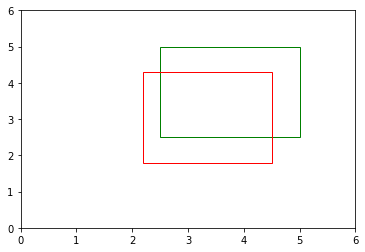

tensor([[ 1.7391e-01,  2.8000e-01,  8.3382e-02, -1.1921e-07]])


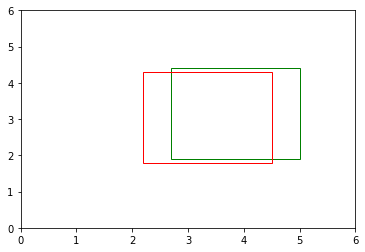

In [42]:
boxes = [[2.5,2.5,5.,5.]]
anchors = [[2.2,1.8,4.5,4.3]]
deltas = [[0.5, 0.1, 0.002, 0.0001]]

show_boxes(gt=boxes, anchor=anchors)

def gt2delta(boxes, anchors):
    """ Convert gt boxes to deltas (center shift and wh ratio in log scale) given anchors. 
    """
    anchors = torch.Tensor(anchors)
    boxes = torch.Tensor(boxes)

    anchors_wh = anchors[:, 2:] - anchors[:, :2]
    anchors_ctr = anchors[:, :2] + anchors_wh * 0.5
    boxes_wh = boxes[:, 2:] - boxes[:, :2]
    boxes_ctr = boxes[:, :2] + boxes_wh * 0.5
    return torch.cat(((boxes_ctr - anchors_ctr) / anchors_wh, torch.log(boxes_wh / anchors_wh)), dim=-1)


def delta2pred(deltas, anchors):
    """ Convert deltas to pred boxes given anchors. 
    """
    anchors = torch.Tensor(anchors)
    deltas = torch.Tensor(deltas)

    anchors_wh = anchors[:, 2:] - anchors[:, :2]
    anchors_ctr = anchors[:, :2] + anchors_wh * 0.5
    pred_ctr = deltas[:, :2] + anchors_ctr
    pred_wh = torch.exp(deltas[:, 2:]) * anchors_wh
    pred_boxes = torch.cat((pred_ctr - 0.5 * pred_wh, pred_ctr + 0.5 * pred_wh), dim=-1)
    
    return pred_boxes

print(gt2delta(boxes, anchors))

pred_boxes = delta2pred(deltas, anchors)
show_boxes(gt=pred_boxes, anchor=anchors)

#### 6. nms
```python
scores = [0.6, 0.9, 0.3, 0, 0.7, 0.4, 0.6, 0.4]
boxes = [[3,4,4.5,5.6001], [2.9,4.1,4.6,5.8002], [2.95,3.8,4.6,5.5003], [3.3,4.9,4.4,6.1004], [5.4,4.2,6.5,6.2005], [5.3,4.5,6.7,6.8006], [5.3,1.7,6.5,3.7007], [5.4,1.8,6.6,3.5008]]
classes = [0,0,0,0,0,0,1,1]
nms_thres = 0.5
```

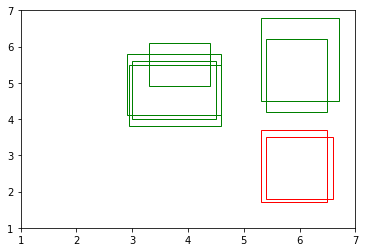

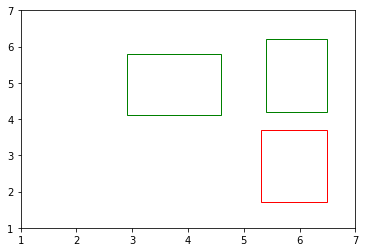

In [86]:
scores = [0.6, 0.9, 0.3, 0, 0.7, 0.4, 0.6, 0.4]
boxes = [[3,4,4.5,5.6001], [2.9,4.1,4.6,5.8002], [2.95,3.8,4.6,5.5003], [3.3,4.9,4.4,6.1004], [5.4,4.2,6.5,6.2005], [5.3,4.5,6.7,6.8006], [5.3,1.7,6.5,3.7007], [5.4,1.8,6.6,3.5008]]
classes = [0,0,0,0,0,0,1,1]
nms_thres = 0.5

show_boxes(lims=(1,7), gt=boxes[:6], anchor=boxes[6:]) # Just use gt and anchor to distinguish different classes. 

def nms(scores, boxes, classes, nms_thres):
    """ Apply nms on input boxes with multiple classes. 
    """
    scores = torch.Tensor(scores)
    boxes = torch.Tensor(boxes)
    classes = torch.Tensor(classes)

    # filter out 0 score boxes
    non_idx = (scores.view(-1) > 0).nonzero()
    scores, boxes, classes = scores[non_idx].view(-1), boxes[non_idx].view(-1, 4), classes[non_idx].view(-1)
    areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) # area of each box. 

    # sort boxes according to the scores
    _, order = torch.sort(scores, dim=0, descending=True)

    keep = []
    while order.numel():
        if order.numel() == 1:
            keep.append(order.item())
            break
        else:
            i = order[0].item()
            keep.append(i)     # append the first box. 

            xy1 = torch.max(boxes[order[1:], :2], boxes[i, :2])
            xy2 = torch.min(boxes[order[1:], 2:], boxes[i, 2:])
            inter = torch.prod((xy2-xy1).clamp(0), dim=-1)

            # boxes that should be saved:
            # 1) the boxes iou with current box is less_equal thres, 2) not same class
            criterion = ((inter / (areas[order[1:]] + areas[i] - inter) <= nms_thres) | (classes[order[1:]] != classes[i])).nonzero() 
            if criterion.numel() == 0:
                break
            order = order[criterion+1].view(-1) # criterion is based on order[1:], so need to add 1 to get new order. 
    return scores[keep], boxes[keep], classes[keep]

_, keep_boxes, keep_classes = nms(scores, boxes, classes, nms_thres)
show_boxes(lims=(1,7), gt=keep_boxes[keep_classes < 1], anchor=keep_boxes[keep_classes == 1])